### TOPIC MODELING WITH BERTOPIC ALGORITHM - NPS DATA
##### This script is for accessing BERT coherence scores used for comparison with other language models such as LDA, LSA etc 

In [1]:
# Importing necessary libraries/packages
import numpy as np
import pandas as pd
import scipy as scs
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
import datetime as dt
import re

import gensim
from gensim.utils import simple_preprocess
import nltk

import gensim.corpora as corpora
from pprint import pprint

#import pyLDAvis.gensim_models
import pickle 
#import pyLDAvis

pd.set_option("display.max_columns", 50, "display.max_rows", 100)

In [2]:
# Authentication
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
proj_name = 'pg-duke-student-capstone-v1'
proj_num = '545682952716'
proj_id =   'pg-duke-student-capstone-v1'
client = bigquery.Client(project=proj_id)

In [4]:
# "pg-duke-student-capstone-v1.final_merged.clean_nps"

sql = """
    WITH A AS
      (SELECT * FROM `pg-duke-student-capstone-v1.final_merged.clean_nps`)
      SELECT * FROM A
      -- limit 10
"""

# Run a Standard SQL query with the project set explicitly
project_id = 'pg-duke-student-capstone-v1'
#data = pd.read_gbq(sql, project_id=project_id, dialect='standard')
data = pd.read_gbq(sql, project_id=proj_id, dialect='standard')
data.head()

,int64_field_0,application_id,product_type,respondent_id,survey_key,created_at,score,zendesk_ticket_id,medium,verbatim,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None
2,1389,841048.0,homeandauto,850431113,o9BFKWnnOducRd4AjQcETyjbHbTj0xQb,2021-04-02 16:57:16+00:00,9,None,None,Working with you was fast and easy and I like ...,2f359d6cde594f309b0989e96ce2454f,2f359d6cde594f309b0989e96ce2454f,male,WI,NaN,56.0,Direct,Desktop,NaN,0.0,<NA>,single,NaN,None
3,1398,1454888.0,homeandauto,1047155544,BHUlqVZW1c5am64nlz3rXnnJop68iqXS,2022-01-06 13:03:58+00:00,10,None,None,My agent was very informed and help make the p...,052feaa8c2a14c94953481e4c0567dd3,052feaa8c2a14c94953481e4c0567dd3,male,CA,NaN,28.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None
4,1419,1544133.0,homeandauto,1075912288,qSi8fsNFAjS3atrE54cmsd52Mec8gsmP,2022-02-17 11:47:16+00:00,10,None,None,I got my insurance for both vehicles cut in ha...,653fc046465e40dc8b3b0f73a17bdcfd,653fc046465e40dc8b3b0f73a17bdcfd,male,LA,NaN,35.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None


In [5]:
# Look at dimensions of the data
print(data.shape)

(13261, 24)


In [6]:
# Rename the verbatim column
data = data.rename(columns={'verbatim': 'comment'})
#print(data)

In [7]:
# Quick browse of customer reviews
data["comment"]

0                                      Listen to problems 
1        My experience with Policy genius was great and...
2        Working with you was fast and easy and I like ...
3        My agent was very informed and help make the p...
4        I got my insurance for both vehicles cut in ha...
                               ...                        
13256       Quickly response with appropriate information 
13257                      very easy and friendly process!
13258    Better rate than anyone. Great customer servic...
13259    Everyone I worked with was very professional, ...
13260    Great overall experience, very easy getting my...
Name: comment, Length: 13261, dtype: object

In [8]:
# Removing the "Nones'
data = data[~data["comment"].astype(str).eq('None')]

In [9]:
#Also drop nas and missing strings from data
# drop rows containing "nas" or empty strings
data = data.dropna(subset=["comment"], axis=0).reset_index(drop=True)

# display the updated DataFrame
print(data.shape)

(13261, 24)


In [10]:
# Dimensions of data after removing nones (data drops by alomst half)
print(data.shape)

(13261, 24)


In [11]:
# Converting the timestamps to day, month and year for later use
# Rename the created_at column
data = data.rename(columns={'created_at': 'response_timestamp'})
data['date'] = pd.to_datetime(data['response_timestamp'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
# df_nps["month-year"] = df_nps.month.astype(str) + "-" + df_nps.year.astype(str)

In [12]:
# Categorize the score - No is not an important step though
data["score_categorized"] = pd.cut(data.score, bins=[-np.inf, 6, 8, 10],
                  labels=["detractor", "passive", "promoter"])


In [13]:
# Check data to see the changes made above
data.head(2)

,int64_field_0,application_id,product_type,respondent_id,survey_key,response_timestamp,score,zendesk_ticket_id,medium,comment,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description,date,day,month,year,score_categorized
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None,2021-10-04 14:04:10+00:00,4,10,2021,promoter
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None,2020-07-24 14:09:47+00:00,24,7,2020,passive


In [14]:
# Check distribution of scores 
data["score"].value_counts()

10    9808
9     1443
8      810
7      320
0      246
5      194
6      157
3       88
2       73
4       66
1       56
Name: score, dtype: Int64

In [15]:
## We see that the scores are all low, could it be related to nps scores for detractors ??
data['score_categorized'].value_counts()

promoter     11251
passive       1130
detractor      880
Name: score_categorized, dtype: int64

In [16]:
# Check the summary of our data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13261 entries, 0 to 13260
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   int64_field_0                 13261 non-null  Int64              
 1   application_id                13261 non-null  float64            
 2   product_type                  13261 non-null  object             
 3   respondent_id                 13261 non-null  Int64              
 4   survey_key                    13261 non-null  object             
 5   response_timestamp            13261 non-null  datetime64[ns, UTC]
 6   score                         13261 non-null  Int64              
 7   zendesk_ticket_id             1086 non-null   object             
 8   medium                        1086 non-null   object             
 9   comment                       13261 non-null  object             
 10  analytics_user_id             1302

In [17]:

#The BERTopic class expects text data in the form of a list of strings containing documents. 
#Therefore, we convert the customer review dataset to a list of strings.
#data_csat_ = data["comment"].tolist()

In [18]:
# Read the first four reviews
#data_csat_[0:5]

In [19]:
## convert from list to string. This string text will help us contectualize topics emerging leter from the algorithm
#data_csat_1 = "".join(data_csat_)
#data_csat_1

In [20]:
# Create a new column containing the length each review text and find the longest review text
data["comment_len"] = data["comment"].apply(lambda x : len(x.split()))
len(data["comment_len"])
print("The longest headline has: {} words".format(data.comment_len.max()))

The longest headline has: 540 words


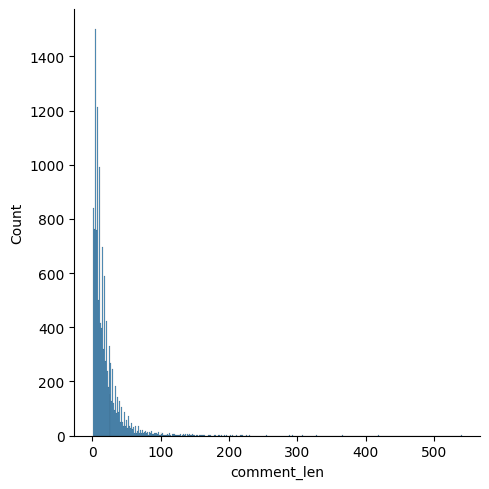

In [21]:
# Visualize the length distribution 
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data.comment_len, kde=False)

## DATA PREPROCESSING 

In [22]:
# install contractions
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
### Importing necessary libraries
import pandas as pd
import nltk
import string
#stopwords
from nltk.corpus import stopwords
#tokenizer
from nltk.tokenize import RegexpTokenizer
#lemmatizer
from nltk.stem import WordNetLemmatizer
#Stemmer
from nltk.stem.porter import PorterStemmer

#contractions
import contractions

#gensims
import gensim
from gensim import models
from gensim.utils import simple_preprocess

In [24]:
#download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# download word net for lemmatizing
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
#DATA PREPROCESSING STEPS
### Removing stopwords, tokenizing data, lemmaziting, converting to lower case, remove panctuations, i 

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 'use', 'policygenius', 'policy', 'genius','insurance', "pg", 'none', 'na', "able", "already", "also",
                   "was", "were", "thus", "although", "always", "bc", "because", "definitely", "could", "couldnt", 'would', "wouldnt"])

def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split('/')]))
    
    # remove emojis
    #text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in stop_words if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    from nltk.stem import WordNetLemmatizer
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # stemming
    #from nltk.stem import PorterStemmer
    #text_col = text_col.apply(lambda x: ' '.join([PorterStemmer().stem(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

In [27]:
# view one instance
data["comment"][3]

'My agent was very informed and help make the process super easy and painless for me. And they got my a policy that ended up saving me money as well. '

In [28]:
# Calling the data preprocessing function above and visualizing same instance as above
npsdata_clean = preprocess(data["comment"])  #[3] # L + stemming
npsdata_clean[3]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'agent informed help make process super easy painless got ended saving money well'

### BERTOPIC ALGORITHM

In [29]:
#The first step for creating a Topic Model with BERTopic is to import the BERTopic class from the bertopic module.
!pip install bertopic
from bertopic import BERTopic
!pip install joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.2.2 requires joblib>=1.1.1, but you have joblib 1.1.0 which is incompatible.
imbalanced-learn 0.10.1 requires joblib>=1.1.1, but you have joblib 1.1.0 which is incompatible.


In [30]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")


### ANALYSIS OF CUSTOMER REVIEWS (NPS DATA) USING BERTOPIC 

In [31]:
##Quick check through the data we are using
npsdata_clean.head()

0                                       listen problem
1                                experience great easy
2                        working fast easy like result
3    agent informed help make process super easy pa...
4    got vehicle cut half amazing mrskrista helpful...
Name: comment, dtype: object

In [32]:
# BERTopic actually requires data in an array format. We convert the data frame texts into a numpy array object.
npsdata_clean1 = np.array(npsdata_clean)   
npsdata_clean1

array(['listen problem', 'experience great easy',
       'working fast easy like result', ...,
       'better rate anyone great customer service friendly knowledgeable staff',
       'everyone worked professional answered question helped navigate choice overall made process simple fast',
       'great overall experience easy getting even though changed provider initial underwriting not sometimes confusing working multiple rep'],
      dtype=object)

In [33]:
#Quick check that the length of data is maintained
len(npsdata_clean1)

13261

In [34]:
# Removing Nas and empty lists from data (Optional step)
#csatdata_clean2 = [x for x in csatdata_clean1 if x not in (None, '')]
# display the updated array
#len(csatdata_clean2)

In [35]:
## Importing the necessary packages for the Bertopic module
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

### Defining function and parameters for tuning models

In [36]:
# Define function for parameters

def create_model(embedding_model_name, umap_params, hdbscan_params, vectorizer_params, ctfidf_params, representation_params):
    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer(embedding_model_name)
    
    # Step 2 - Reduce dimensionality
    umap_model = UMAP(**umap_params)
    
    # Step 3 - Cluster reduced embeddings
    hdbscan_model = HDBSCAN(**hdbscan_params)
    
    # Step 4 - Tokenize topics and create ngrams
    vectorizer_model = CountVectorizer(**vectorizer_params)
    
    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer(**ctfidf_params)
    
    # Step 6 - (Optional) Fine-tune topic representations with 
    # a `bertopic.representation` model
    representation_model = KeyBERTInspired(**representation_params)
    
    return embedding_model, umap_model, hdbscan_model, vectorizer_model, ctfidf_model, representation_model

In [37]:
# Defining parameters for tuning models using function above (We do this to avoid instantiating parameters everytime)

# First set of parameters
umap_params_1 = {'random_state': 12324}
hdbscan_params_1 = {'prediction_data': True}
vectorizer_params_1 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_1 = {}
representation_params_1 = {}

embedding_model_1, umap_model_1, hdbscan_model_1, vectorizer_model_1, ctfidf_model_1, representation_model_1 = create_model(
    "all-MiniLM-L6-v2", umap_params_1, hdbscan_params_1, vectorizer_params_1, ctfidf_params_1, representation_params_1)


# Second set of parameters
umap_params_2 = {'random_state': 150, 'n_neighbors': 15, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_2 = {'min_cluster_size': 10, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_2 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_2 = {}
representation_params_2 = {}

embedding_model_2, umap_model_2, hdbscan_model_2, vectorizer_model_2, ctfidf_model_2, representation_model_2 = create_model(
    "all-MiniLM-L6-v2", umap_params_2, hdbscan_params_2, vectorizer_params_2, ctfidf_params_2, representation_params_2)


# Third set of parameters
umap_params_3 = {'random_state': 150, 'n_neighbors': 15, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_3 = {'min_cluster_size': 9, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_3 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_3 = {}
representation_params_3 = {}

embedding_model_3, umap_model_3, hdbscan_model_3, vectorizer_model_3, ctfidf_model_3, representation_model_3 = create_model(
    "all-MiniLM-L6-v2", umap_params_3, hdbscan_params_3, vectorizer_params_3, ctfidf_params_3, representation_params_3)


# Fourth set of parameters
umap_params_4 = {'random_state': 150, 'n_neighbors': 15, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_4 = {'min_cluster_size': 18, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_4 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_4 = {}
representation_params_4 = {}

embedding_model_4, umap_model_4, hdbscan_model_4, vectorizer_model_4, ctfidf_model_4, representation_model_4 = create_model(
    "all-MiniLM-L6-v2", umap_params_4, hdbscan_params_4, vectorizer_params_4, ctfidf_params_4, representation_params_4)



#### Function for coherence

In [38]:
import pandas as pd
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

# coherence score in topic modeling to measure how interpretable the topics are to humans.
# coherence score - Evaluate the semantic coherence of a set of topics by measuring the degree of semantic similarity between the top words in each topic. 
# A high coherence score implies -  that the topics are more coherent, words within each topic are more semantically related, 
# A high coherence score implies - generated topics are more interpretable, useful for downstream tasks e.g document clustering, classification, or retrieval

# Function to create coherence score
def evaluate_coherence(docs, topics, topic_model):
    
    # Group docs by topic and preprocess them
    documents = pd.DataFrame({"Document": docs, "ID": range(len(docs)), "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document':' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)


    # Extract vectorizer and analyzer from BERTopic
    vectorizer  = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    #words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]

    # Extract features for Topic Coherence evaluation
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

    # Removing any empty strings
    topic_words = [[x for x in sub_arr if x not in ('', None)] for sub_arr in topic_words]

    # Evaluate coherence
    coherence_model = CoherenceModel(topics=topic_words, texts=tokens, 
                                     corpus=corpus, dictionary=dictionary, coherence= 'c_v')
    coherence = coherence_model.get_coherence()
    
    return coherence

#### MODELING

In [110]:
# Start with Automated topics
topic_model_nps = BERTopic(nr_topics= 'auto', 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [111]:
# produce topics and probablities
topics_auto, probs_auto = topic_model_nps.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 20:55:22,943 - BERTopic - Transformed documents to Embeddings
2023-04-12 20:55:39,023 - BERTopic - Reduced dimensionality
2023-04-12 20:55:39,539 - BERTopic - Clustered reduced embeddings
2023-04-12 20:56:15,773 - BERTopic - Reduced number of topics from 433 to 299


In [112]:
## COHERENCE SCORE CALCULATION
#coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_auto, topic_model_nps)
#print(f"The coherence score is: {coherence_score_auto}")

In [113]:
#Topics Visualization.¶
#The topic visualization helps in gaining more insight about each topic. 
#BERTopic provides several visualization possibilities such as terms visualization, intertopic distance map, 
#topic hierarchy clustering just to name a few.
# The visual below could help guide the topic formulation process.
topic_model_nps.visualize_topics()

## Tuning for clusters 10, 9, 8,6,5 and 4 

####10 clusters

In [39]:
# Start with Automated topics
topic_model_nps_10 = BERTopic(nr_topics= 10, 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [115]:
# produce topics and probablities
topics_10, probs_10 = topic_model_nps_10.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 20:58:34,407 - BERTopic - Transformed documents to Embeddings
2023-04-12 20:58:49,775 - BERTopic - Reduced dimensionality
2023-04-12 20:58:50,263 - BERTopic - Clustered reduced embeddings
2023-04-12 20:59:12,370 - BERTopic - Reduced number of topics from 433 to 10


In [116]:
## COHERENCE SCORE CALCULATION
coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_10, topic_model_nps_10)
print(f"The coherence score is: {coherence_score_auto}")

The coherence score is: 0.6477746082966618


In [117]:
topic_model_nps_10.visualize_topics()

###9 clusters

In [40]:
# Start with Automated topics
topic_model_nps_9 = BERTopic(nr_topics= 9, 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [41]:
# produce topics and probablities
topics_9, probs_9 = topic_model_nps_9.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 21:25:41,092 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:26:16,002 - BERTopic - Reduced dimensionality
2023-04-12 21:26:16,496 - BERTopic - Clustered reduced embeddings
2023-04-12 21:26:37,922 - BERTopic - Reduced number of topics from 433 to 9


In [42]:
## COHERENCE SCORE CALCULATION
coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_9, topic_model_nps_9)
print(f"The coherence score is: {coherence_score_auto}")

The coherence score is: 0.5977240513643922


In [43]:
topic_model_nps_9.visualize_topics()

###8 clusters

In [44]:
# Start with Automated topics
topic_model_nps_8 = BERTopic(nr_topics= 8, 
  embedding_model = embedding_model_2,    # Step 1 - Extract embeddings
  umap_model = umap_model_2,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_2,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_2,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_2,
  representation_model = representation_params_2,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [45]:
# produce topics and probablities
topics_8, probs_8 = topic_model_nps_8.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 21:31:37,366 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:32:08,446 - BERTopic - Reduced dimensionality
2023-04-12 21:32:09,118 - BERTopic - Clustered reduced embeddings
2023-04-12 21:32:20,999 - BERTopic - Reduced number of topics from 208 to 8


In [46]:
## COHERENCE SCORE CALCULATION
coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_8, topic_model_nps_8)
print(f"The coherence score is: {coherence_score_auto}")

The coherence score is: 0.6197231147793314


In [47]:
topic_model_nps_8.visualize_topics()

###7 clusters

In [48]:
# Start with Automated topics
topic_model_nps_7 = BERTopic(nr_topics= 7, 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [49]:
# produce topics and probablities
topics_7, probs_7 = topic_model_nps_7.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 21:35:27,721 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:35:44,184 - BERTopic - Reduced dimensionality
2023-04-12 21:35:44,679 - BERTopic - Clustered reduced embeddings
2023-04-12 21:36:04,224 - BERTopic - Reduced number of topics from 433 to 7


In [50]:
## COHERENCE SCORE CALCULATION
coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_7, topic_model_nps_7)
print(f"The coherence score is: {coherence_score_auto}")

The coherence score is: 0.5717461306979097


In [51]:
topic_model_nps_7.visualize_topics()

###6 clusters

In [52]:
# Start with Automated topics
topic_model_nps_6 = BERTopic(nr_topics= 6, 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [53]:
# produce topics and probablities
topics_6, probs_6 = topic_model_nps_6.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 21:38:25,049 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:38:40,084 - BERTopic - Reduced dimensionality
2023-04-12 21:38:40,575 - BERTopic - Clustered reduced embeddings
2023-04-12 21:39:01,578 - BERTopic - Reduced number of topics from 433 to 6


In [54]:
## COHERENCE SCORE CALCULATION
coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_6, topic_model_nps_6)
print(f"The coherence score is: {coherence_score_auto}")

The coherence score is: 0.6025521455223208


In [55]:
topic_model_nps_6.visualize_topics()

###5 clusters

In [56]:
# Start with Automated topics
topic_model_nps_5 = BERTopic(nr_topics= 5, 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [57]:
# produce topics and probablities
topics_5, probs_5 = topic_model_nps_5.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 21:41:33,200 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:41:48,206 - BERTopic - Reduced dimensionality
2023-04-12 21:41:48,723 - BERTopic - Clustered reduced embeddings
2023-04-12 21:42:08,369 - BERTopic - Reduced number of topics from 433 to 5


In [58]:
## COHERENCE SCORE CALCULATION
coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_5, topic_model_nps_5)
print(f"The coherence score is: {coherence_score_auto}")

The coherence score is: 0.6038131058476284


In [59]:
topic_model_nps_5.visualize_topics()

###4 clusters

In [60]:
# Start with Automated topics
topic_model_nps_4 = BERTopic(nr_topics= 4, 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [61]:
# produce topics and probablities
topics_4, probs_4 = topic_model_nps_4.fit_transform(npsdata_clean1)

Batches:   0%|          | 0/415 [00:00<?, ?it/s]

2023-04-12 21:46:09,231 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:46:25,975 - BERTopic - Reduced dimensionality
2023-04-12 21:46:26,513 - BERTopic - Clustered reduced embeddings
2023-04-12 21:46:45,679 - BERTopic - Reduced number of topics from 433 to 4


In [62]:
## COHERENCE SCORE CALCULATION
coherence_score_auto = evaluate_coherence(npsdata_clean1, topics_4, topic_model_nps_4)
print(f"The coherence score is: {coherence_score_auto}")

The coherence score is: 0.5023047989100914


In [71]:
#topic_model_nps_4.visualize_topics()